In [7]:
from transformers import ViTImageProcessor, ViTModel
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from pathlib import Path
import torch
import numpy as np

In [3]:
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb8')
model = ViTModel.from_pretrained('facebook/dino-vitb8')

def get_stims():
    output_dir = '/media/maria/DATA/AllenData'

    boc = BrainObservatoryCache(
        manifest_file=str(Path(output_dir) / 'brain_observatory_manifest.json'))

    # Choose random experiment-- the stimuli are the same
    Emx1_exps = boc.get_experiment_containers(cre_lines=['Emx1-IRES-Cre'])
    Emx1_id = Emx1_exps[0]['id']
    exps = boc.get_ophys_experiments(experiment_container_ids=[Emx1_id])
    exp = exps[0]
    data_set = boc.get_ophys_experiment_data(exp['id'])
    movie_stims = data_set.get_stimulus_template('natural_movie_one')
    scenes_stims = data_set.get_stimulus_template('natural_scenes')
    return movie_stims, scenes_stims

movie_stims, _ = get_stims()

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
print(movie_stims.shape)
stims = np.repeat(movie_stims[:, np.newaxis, :, :], 3, axis=1)
processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb8')
model = ViTModel.from_pretrained('facebook/dino-vitb8')

n_stims = len(stims)
dino_features = np.empty((n_stims, 768))
for i in range(99,100):
    print(i)
    inputs = processor(images=stims[i], return_tensors="pt")
    print('pixs',inputs['pixel_values'].shape)
    with torch.no_grad():
        outputs = model(**inputs,output_attentions=True)
        # print(outputs.keys())
    #last_hidden_states = outputs.last_hidden_state
    #print(last_hidden_states.shape)
    print(outputs.attentions[0])

(900, 304, 608)


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


99
pixs torch.Size([1, 3, 224, 224])
tensor([[[[7.3835e-02, 2.4208e-03, 2.2896e-03,  ..., 1.4599e-03,
           2.3555e-03, 2.4170e-03],
          [1.8596e-01, 4.0952e-03, 3.3342e-03,  ..., 8.7562e-04,
           1.5172e-03, 1.5178e-03],
          [1.9485e-01, 3.2673e-03, 2.6330e-03,  ..., 1.0276e-03,
           1.8867e-03, 1.8830e-03],
          ...,
          [3.6982e-02, 2.8244e-03, 2.6318e-03,  ..., 1.2339e-03,
           1.7371e-03, 1.7665e-03],
          [5.0790e-02, 3.6182e-03, 3.2563e-03,  ..., 1.0596e-03,
           1.4789e-03, 1.4938e-03],
          [1.2411e-01, 2.1703e-03, 1.8353e-03,  ..., 1.5603e-03,
           2.8353e-03, 2.8390e-03]],

         [[1.3797e-01, 2.1725e-03, 3.2105e-03,  ..., 3.1305e-03,
           3.4205e-03, 3.4973e-03],
          [3.2939e-01, 1.9398e-03, 2.8853e-03,  ..., 2.7486e-03,
           3.4385e-03, 3.5431e-03],
          [1.4238e-01, 2.2042e-03, 3.1431e-03,  ..., 2.9844e-03,
           3.4571e-03, 3.5447e-03],
          ...,
          [1.5044e-01,

In [56]:
224/8
28*28

784

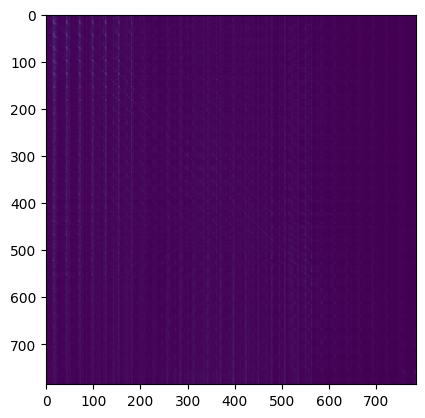

In [39]:
import matplotlib.pyplot as plt

plt.imshow(outputs.attentions[11].detach().numpy()[0,2,:,:])

In [40]:
print(outputs.attentions[11].shape)

torch.Size([1, 12, 785, 785])


torch.Size([785, 785, 12])


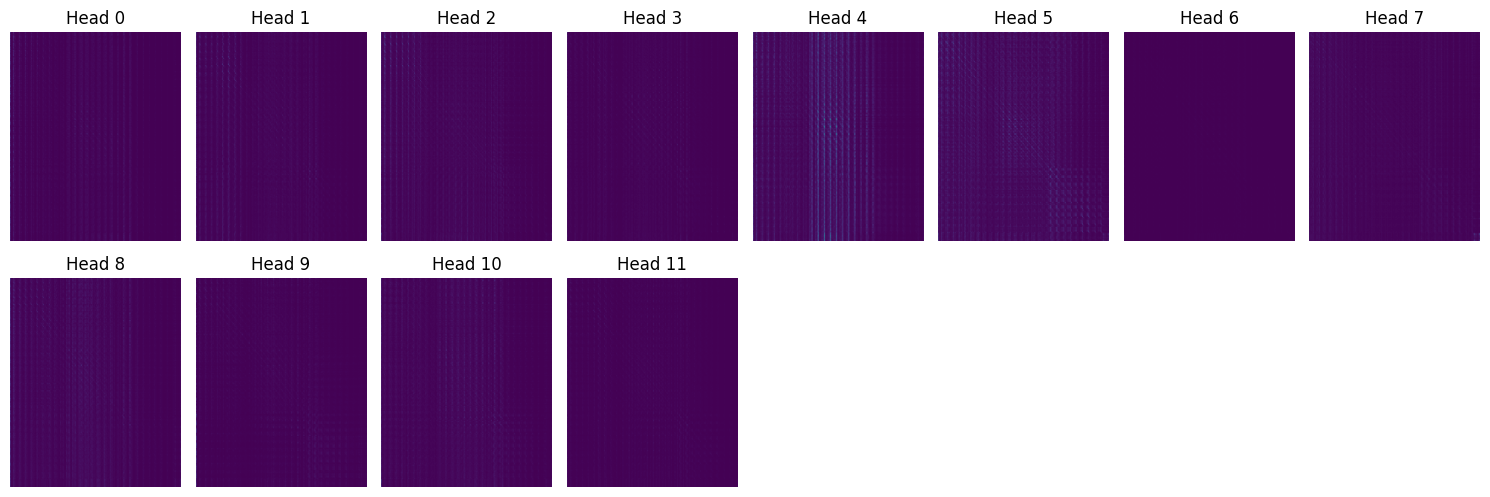

In [41]:
# Reshape attention weights for visualization
num_layers, num_heads, seq_len, _ = outputs.attentions[11].shape
attention_weights = outputs.attentions[11].permute(0, 2, 3, 1).reshape(-1, seq_len, num_heads)
print(attention_weights.shape)
# Plot attention maps for each head
plt.figure(figsize=(15, 10))
for head in range(num_heads):
    plt.subplot(4, 8, head + 1)  # Change subplot dimensions if needed
    plt.imshow(attention_weights[:, :, head], cmap='viridis', aspect='auto')
    plt.title(f'Head {head}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [66]:
from torch import nn
patch_size=8

img=torch.Tensor(stims[99])
#w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        #img.shape[2] % patch_size
#img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

nh=12

attention_weights=outputs.attentions[11]
attentions = attention_weights[0, :, 2, 1:].reshape(nh, -1)
print(attentions.shape)

attentions = attentions.reshape(nh, 28, 28)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([12, 784])


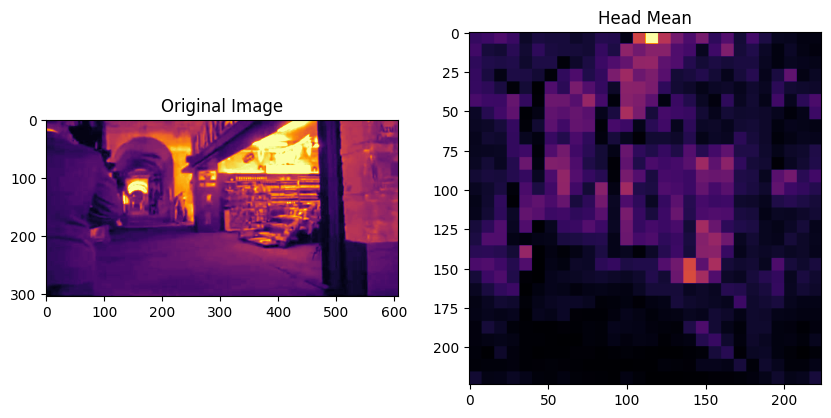

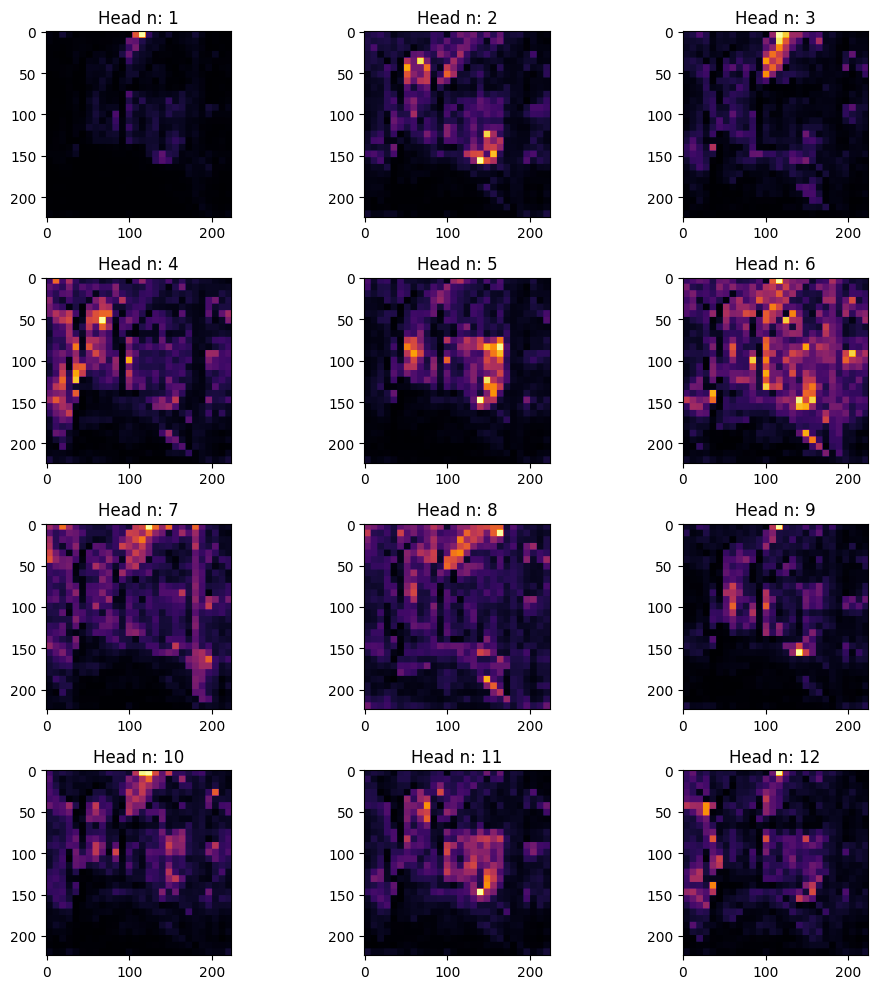

In [67]:
def plot_attention(img, attention):
    img=img[0,:,:]
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()

plot_attention(img, attentions)

In [63]:
print(outputs.attentions[11].shape)

torch.Size([1, 12, 785, 785])
